# Regional wage deflators

Does the use of the regional CPI-U change the wage estimate picture for low-wage workers?

-----

January 30, 2019

Brian Dew, @bd_econ


-----

Check whether inflation is overstated for low wage workers. 

My suspicion is based on a few observations:

1) Real wage estimates nearly always adjust for changing prices using the consumer price index for all urban consumers (CPI-U), or the historical CPI-U updated to current methods (CPI-U-RS).

2) But the regional CPI-U shows higher rates of inflation in the west region

3) And low-wage workers tend to be in the south and midwest (places where the local minimum wage is more likely to be the federal minimum wage)

Therefore, measures of real wages and real wage growth at the bottom of the wage distribution may be biased by the choice of the wage deflator.

To check this, calculate the real wage at the first decile using the CPI-U and again using the regional CPI-U.

Two possible graphs: 

1) Share of bottom 10% of wage earners living in the south or midwest. 

2) First decile real wage showing two lines, one with each deflator.

Then write up the results.


-----

Background and references:

[Smith and Woodbury (2000)](https://www.urban.org/sites/default/files/publication/62251/309642-The-Low-Wage-Labor-Market-Challenges-and-Opportunities-for-Economic-Self-Sufficiency.PDF)

In [1]:
import pandas as pd
import numpy as np
import os, pickle

os.chdir('/home/brian/Documents/CPS/data/')

cpi = pd.read_csv('clean/cpi.csv', index_col=[0], parse_dates=True)

def pct_wage(group):
    """Return BLS-styled binned first decile wage"""
    d = pd.DataFrame()
    year = group['YEAR'].iloc[0]
    month = group['MONTH'].iloc[0]
    date = pd.to_datetime(f'{year}-{month}-01')
    weight = 'PWORWGT'
    percentile = 0.05
    bin_size = 0.5 #($0.50)
    bins = list(np.arange(0.25, 300, bin_size))
    for wage_var in ['RHRWAGE', 'RHRWAGE2']:
        bin_cut = lambda x: pd.cut(x[wage_var], bins, include_lowest=True)
        cum_sum = lambda x: x[weight].cumsum()
        dft = (group.sort_values(wage_var)
                    .assign(WAGE_RANGE = bin_cut, CS = cum_sum))
        pct_point = dft[weight].sum() * percentile
        pct_bin = (dft.iloc[(dft['CS'] - pct_point).abs().argsort()[:1]]
                      .WAGE_RANGE.values[0])
        wage_bins = list(dft['WAGE_RANGE'].unique())
        pct_loc = wage_bins.index(pct_bin)
        bin_below = dft[dft['WAGE_RANGE'] == wage_bins[pct_loc-1]].iloc[-1].CS
        bin_above = dft[dft['WAGE_RANGE'] == wage_bins[pct_loc]].iloc[-1].CS
        pct_value = ((((pct_point - bin_below) / 
                       (bin_above - bin_below)) * bin_size) + pct_bin.left)
        if wage_var == 'RHRWAGE':
            d.at[date, 'Regional CPI'] = pct_value
    
        if wage_var == 'RHRWAGE2':
            d.at[date, 'Regular CPI'] = pct_value
    return d

cpsdd = pickle.load(open('cps_basic_dd.pkl', 'rb'))

regions_map = cpsdd['January_2017_Record_Layout.txt']['map']['region']

regions_map

{'AK': 'West',
 'HI': 'West',
 'WA': 'West',
 'OR': 'West',
 'CA': 'West',
 'NV': 'West',
 'ID': 'West',
 'MT': 'West',
 'UT': 'West',
 'AZ': 'West',
 'CO': 'West',
 'WY': 'West',
 'NM': 'West',
 'ND': 'Midwest',
 'SD': 'Midwest',
 'NE': 'Midwest',
 'KS': 'Midwest',
 'MN': 'Midwest',
 'IA': 'Midwest',
 'MO': 'Midwest',
 'WI': 'Midwest',
 'IL': 'Midwest',
 'IN': 'Midwest',
 'MI': 'Midwest',
 'OH': 'Midwest',
 'TX': 'South',
 'OK': 'South',
 'AR': 'South',
 'LA': 'South',
 'MS': 'South',
 'AL': 'South',
 'TN': 'South',
 'KY': 'South',
 'WV': 'South',
 'VA': 'South',
 'MD': 'South',
 'DE': 'South',
 'DC': 'South',
 'NC': 'South',
 'SC': 'South',
 'GA': 'South',
 'FL': 'South',
 'PA': 'Northeast',
 'NJ': 'Northeast',
 'NY': 'Northeast',
 'CT': 'Northeast',
 'RI': 'Northeast',
 'MA': 'Northeast',
 'NH': 'Northeast',
 'VT': 'Northeast',
 'ME': 'Northeast'}

## Motivation/background

In [2]:
columns = ['MONTH', 'AGE', 'EMP', 'HRWAGE', 'STATE', 'BASICWGT', 'PWORWGT']
df = (pd.read_feather('clean/cps2018.ft', columns=columns)
        .query('MONTH==11')
        .assign(REGION = lambda x: x['STATE'].map(regions_map)))

#### What share of the population (all ages, including children) lives in each region?

In [3]:
data = df.groupby('REGION').BASICWGT.sum()

data / data.sum() * 100

REGION
Midwest      20.806034
Northeast    17.640844
South        37.789581
West         23.763548
Name: BASICWGT, dtype: float32

#### What share of the age 16-64 population lives in each region?

A: about the same, 58% are in the south or midwest

In [4]:
data = df.query('16 <= AGE <= 64').groupby('REGION').BASICWGT.sum()

data / data.sum() * 100

REGION
Midwest      20.851215
Northeast    17.344915
South        37.623241
West         24.180637
Name: BASICWGT, dtype: float32

#### What share of people making $8/hr or less live in each region?

A: Much less likely in the west and much more likely in the south. 70% are in the south and midwest.

In [5]:
data = df.query('HRWAGE <= 8').groupby('REGION').PWORWGT.sum()

data / data.sum() * 100

REGION
Midwest      19.220295
Northeast    16.297894
South        51.336334
West         13.145478
Name: PWORWGT, dtype: float32

#### How does inflation vary by region?

A: Higher than total in the west and lower that total in the midwest and south

In [6]:
# Inflation rate as of December 2018, ALL and regions
(cpi.iloc[-13] - 1) * 100

ALL          1.910159
Northeast    1.723602
Midwest      1.262210
South        1.525290
West         3.055019
Name: 2017-12-01 00:00:00, dtype: float64

## Time series for a longer-term look

#### What is the wage trend at the fifth percentile* using the regional CPI for price adjustments?

*Wage where about five percent of workers make less and 95 percent make more

In [7]:
columns = ['YEAR', 'MONTH', 'RHRWAGE', 'RHRWAGE2', 'PWORWGT']
data = pd.DataFrame()
for year in range(1989, 2019):
    df = (pd.read_feather(f'clean/cps{year}.ft', columns=columns)
            .query('RHRWAGE > 0')
            .groupby(['YEAR', 'MONTH'])
            .apply(pct_wage)
            .reset_index()
            .set_index('level_2')
            .drop(['YEAR', 'MONTH'], axis=1))
    data = data.append(df[['Regional CPI', 'Regular CPI']], sort=True)

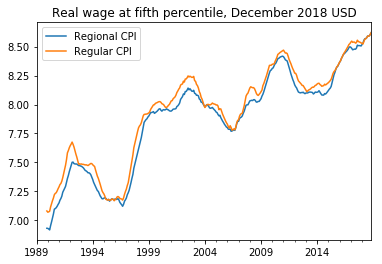

In [8]:
%matplotlib inline
title = 'Real wage at fifth percentile, December 2018 USD'
ax = data.rolling(12).mean().plot(title=title)
ax.set_xlabel('')
fig = ax.get_figure()
fig.savefig('/home/brian/Documents/blog_posts/Regional_CPI_Wages/rw_by_cpi.png');